In [26]:
# Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import warnings
warnings.simplefilter('ignore')

In [27]:
exp_name = 'exp000'
seed = 42

# plot style
pd.set_option('display.max_columns', 200)
plt.rcParams['axes.facecolor'] = 'EEFFFE'

In [28]:
# Data
train = pd.read_csv(r"input/train.csv")
test = pd.read_csv(r"input/test.csv")
sub = pd.read_csv(r"input/sample_submission.csv")

# 前処理

In [29]:
# object(欠測) -> float
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train_df = train.replace('欠測', np.nan)
lgb_imp = IterativeImputer(
                       estimator=LGBMRegressor(num_boost_round=1000, random_state=seed),
                       max_iter=10, 
                       initial_strategy='mean',
                       imputation_order='ascending',
                       verbose=1,
                       random_state=seed)

train_df = pd.DataFrame(lgb_imp.fit_transform(train_df), columns=train_df.columns)
train_df[['winddirection_chiba', 'winddirection_tokyo']] = train_df[['winddirection_chiba', 'winddirection_tokyo']].round().astype(int)
train_df[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']] = train_df[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']].round(1)
train[train.select_dtypes(object).columns] = train_df[train.select_dtypes(object).columns]
train.head(3)

[IterativeImputer] Completing matrix with shape (12168, 16)
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[IterativeImputer] Change: 8.828120105598833, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1,15,16,4.0,1.7,0.6,4.0,32.0,12.0


# 特徴量

In [30]:
# 基本時間特徴
def add_time_feat(df):
    df['time'] = pd.to_datetime(df.datetime.astype(str).str[:-2])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df.datetime.astype(str).str[-2:].astype(int)
    df['weekday'] = df['time'].dt.weekday
    df['day_of_year'] = df['time'].dt.dayofyear
    df['day_of_year'] = df.apply(lambda x: x['day_of_year']-1 if (x['time'] > pd.Timestamp('2020-02-29')) else x['day_of_year'], axis=1)
    df['day_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
    df['day_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365))
    return df

# ラグ特徴
def add_lag_feat(df, feat:list, group:str):
    outputs = [df]
    grp_df = df.groupby(group)
    for lag in [1, 2, 3, 4, 5]:
      # shift
      outputs.append(grp_df[feat].shift(lag).add_prefix(f'shift{lag}_'))
      # diff
      outputs.append(grp_df[feat].diff(lag).add_prefix(f'diff{lag}_'))
    # rolling
    for window in [3,24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f'rolling{window}_mean_')
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)

# 集計特徴
def additional_encoding(train, test, cat_col:list, num_col:list): 
    trdf = train.copy()
    tedf = test.copy()  

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf['month']==4)&(trdf['day']<15)][ccol].value_counts()
        trdf[f'ce_{ccol}'] = trdf[ccol].map(encoder)
        tedf[f'ce_{ccol}'] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ['mean', 'std', 'min', 'max']
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df['abs_mean'] = np.abs(agg_df['mean'])
            agg_df['min_max'] = agg_df['min']*agg_df['max']
            agg_df.columns = [f'{ccol}_{c}' for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how='left')
            tedf = tedf.merge(agg_df, on=ccol, how='left')

    return trdf, tedf

In [31]:
def run_add_feat(train, test):
    # 連結して全データに対して処理
    df = pd.concat([train, test]).reset_index(drop=True)

    # 基本時間特徴の追加
    df = add_time_feat(df)

    # 手動特徴の追加
    windd_col = ['winddirection_utsunomiya', 'winddirection_chiba', 'winddirection_tokyo']
    winds_col = ['windspeed_utsunomiya', 'windspeed_chiba', 'windspeed_tokyo']
    for d, s in zip(windd_col, winds_col):
        df[f'{d}_{s}'] = np.sin(df[windd_col] * (2 * np.pi / 17))[d] * df[s]
    precipitation_col = ['precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo']
    
    # ラグ特徴の追加
    feat = [
    'precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo', 
    'temperature_utsunomiya', 'temperature_chiba', 'temperature_tokyo', 
    'windspeed_utsunomiya', 'windspeed_chiba', 'windspeed_tokyo',
    'winddirection_utsunomiya', 'winddirection_chiba', 'winddirection_tokyo'
    ]
    df = add_lag_feat(df, feat, 'year')

    # train/testに再分割、欠損処理
    train_df = df[:len(train)]
    test_df = df[len(train):]
    train_df = train_df.dropna().reset_index(drop=True)

    # 集計特徴の追加
    cat_columns = ['year', 'month', 'day', 'hour', 'winddirection_utsunomiya', 'winddirection_chiba', 'winddirection_tokyo']
    num_columns = ['precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo', 
               'temperature_utsunomiya', 'temperature_chiba', 'temperature_tokyo', 
               'windspeed_utsunomiya', 'windspeed_chiba', 'windspeed_tokyo']
    train_df, test_df = additional_encoding(train_df, test_df, cat_columns, num_columns)

    return train_df, test_df

train_df, test_df = run_add_feat(train, test)
print(train_df.shape)
display(train_df.head(3))
print(test_df.shape)
display(test_df.head(3))

(12148, 557)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo,time,year,month,day,hour,weekday,day_of_year,day_sin,day_cos,winddirection_utsunomiya_windspeed_utsunomiya,winddirection_chiba_windspeed_chiba,winddirection_tokyo_windspeed_tokyo,shift1_precipitation_utsunomiya,shift1_precipitation_chiba,shift1_precipitation_tokyo,shift1_temperature_utsunomiya,shift1_temperature_chiba,shift1_temperature_tokyo,shift1_windspeed_utsunomiya,shift1_windspeed_chiba,shift1_windspeed_tokyo,shift1_winddirection_utsunomiya,shift1_winddirection_chiba,shift1_winddirection_tokyo,diff1_precipitation_utsunomiya,diff1_precipitation_chiba,diff1_precipitation_tokyo,diff1_temperature_utsunomiya,diff1_temperature_chiba,diff1_temperature_tokyo,diff1_windspeed_utsunomiya,diff1_windspeed_chiba,diff1_windspeed_tokyo,diff1_winddirection_utsunomiya,diff1_winddirection_chiba,diff1_winddirection_tokyo,shift2_precipitation_utsunomiya,shift2_precipitation_chiba,shift2_precipitation_tokyo,shift2_temperature_utsunomiya,shift2_temperature_chiba,shift2_temperature_tokyo,shift2_windspeed_utsunomiya,shift2_windspeed_chiba,shift2_windspeed_tokyo,shift2_winddirection_utsunomiya,shift2_winddirection_chiba,shift2_winddirection_tokyo,diff2_precipitation_utsunomiya,diff2_precipitation_chiba,diff2_precipitation_tokyo,diff2_temperature_utsunomiya,diff2_temperature_chiba,diff2_temperature_tokyo,diff2_windspeed_utsunomiya,diff2_windspeed_chiba,diff2_windspeed_tokyo,diff2_winddirection_utsunomiya,diff2_winddirection_chiba,diff2_winddirection_tokyo,shift3_precipitation_utsunomiya,shift3_precipitation_chiba,shift3_precipitation_tokyo,shift3_temperature_utsunomiya,shift3_temperature_chiba,shift3_temperature_tokyo,shift3_windspeed_utsunomiya,shift3_windspeed_chiba,shift3_windspeed_tokyo,shift3_winddirection_utsunomiya,shift3_winddirection_chiba,shift3_winddirection_tokyo,diff3_precipitation_utsunomiya,diff3_precipitation_chiba,diff3_precipitation_tokyo,diff3_temperature_utsunomiya,diff3_temperature_chiba,diff3_temperature_tokyo,diff3_windspeed_utsunomiya,diff3_windspeed_chiba,diff3_windspeed_tokyo,diff3_winddirection_utsunomiya,diff3_winddirection_chiba,diff3_winddirection_tokyo,...,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean,winddirection_chiba_std,winddirection_chiba_min,winddirection_chiba_max,winddirection_chiba_abs_mean,winddirection_chiba_min_max,winddirection_tokyo_mean_x,winddirection_tokyo_std_x,winddirection_tokyo_min_x,winddirection_tokyo_max_x,winddirection_tokyo_abs_mean_x,winddirection_tokyo_min_max_x,winddirection_tokyo_mean_y,winddirection_tokyo_std_y,winddirection_tokyo_min_y,winddirection_tokyo_max_y,winddirection_tokyo_abs_mean_y,winddirection_tokyo_min_max_y,winddi

(336, 557)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo,time,year,month,day,hour,weekday,day_of_year,day_sin,day_cos,winddirection_utsunomiya_windspeed_utsunomiya,winddirection_chiba_windspeed_chiba,winddirection_tokyo_windspeed_tokyo,shift1_precipitation_utsunomiya,shift1_precipitation_chiba,shift1_precipitation_tokyo,shift1_temperature_utsunomiya,shift1_temperature_chiba,shift1_temperature_tokyo,shift1_windspeed_utsunomiya,shift1_windspeed_chiba,shift1_windspeed_tokyo,shift1_winddirection_utsunomiya,shift1_winddirection_chiba,shift1_winddirection_tokyo,diff1_precipitation_utsunomiya,diff1_precipitation_chiba,diff1_precipitation_tokyo,diff1_temperature_utsunomiya,diff1_temperature_chiba,diff1_temperature_tokyo,diff1_windspeed_utsunomiya,diff1_windspeed_chiba,diff1_windspeed_tokyo,diff1_winddirection_utsunomiya,diff1_winddirection_chiba,diff1_winddirection_tokyo,shift2_precipitation_utsunomiya,shift2_precipitation_chiba,shift2_precipitation_tokyo,shift2_temperature_utsunomiya,shift2_temperature_chiba,shift2_temperature_tokyo,shift2_windspeed_utsunomiya,shift2_windspeed_chiba,shift2_windspeed_tokyo,shift2_winddirection_utsunomiya,shift2_winddirection_chiba,shift2_winddirection_tokyo,diff2_precipitation_utsunomiya,diff2_precipitation_chiba,diff2_precipitation_tokyo,diff2_temperature_utsunomiya,diff2_temperature_chiba,diff2_temperature_tokyo,diff2_windspeed_utsunomiya,diff2_windspeed_chiba,diff2_windspeed_tokyo,diff2_winddirection_utsunomiya,diff2_winddirection_chiba,diff2_winddirection_tokyo,shift3_precipitation_utsunomiya,shift3_precipitation_chiba,shift3_precipitation_tokyo,shift3_temperature_utsunomiya,shift3_temperature_chiba,shift3_temperature_tokyo,shift3_windspeed_utsunomiya,shift3_windspeed_chiba,shift3_windspeed_tokyo,shift3_winddirection_utsunomiya,shift3_winddirection_chiba,shift3_winddirection_tokyo,diff3_precipitation_utsunomiya,diff3_precipitation_chiba,diff3_precipitation_tokyo,diff3_temperature_utsunomiya,diff3_temperature_chiba,diff3_temperature_tokyo,diff3_windspeed_utsunomiya,diff3_windspeed_chiba,diff3_windspeed_tokyo,diff3_winddirection_utsunomiya,diff3_winddirection_chiba,diff3_winddirection_tokyo,...,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean_x,winddirection_chiba_std_x,winddirection_chiba_min_x,winddirection_chiba_max_x,winddirection_chiba_abs_mean_x,winddirection_chiba_min_max_x,winddirection_chiba_mean_y,winddirection_chiba_std_y,winddirection_chiba_min_y,winddirection_chiba_max_y,winddirection_chiba_abs_mean_y,winddirection_chiba_min_max_y,winddirection_chiba_mean,winddirection_chiba_std,winddirection_chiba_min,winddirection_chiba_max,winddirection_chiba_abs_mean,winddirection_chiba_min_max,winddirection_tokyo_mean_x,winddirection_tokyo_std_x,winddirection_tokyo_min_x,winddirection_tokyo_max_x,winddirection_tokyo_abs_mean_x,winddirection_tokyo_min_max_x,winddirection_tokyo_mean_y,winddirection_tokyo_std_y,winddirection_tokyo_min_y,winddirection_tokyo_max_y,winddirection_tokyo_abs_mean_y,winddirection_tokyo_min_max_y,winddi

In [32]:
train_df["year_mean_x"]

,year_mean_x,year_mean_x,year_mean_x,year_mean_x
0,0.108762,0.095688,14.689402,3.074715
1,0.108762,0.095688,14.689402,3.074715
2,0.108762,0.095688,14.689402,3.074715
3,0.108762,0.095688,14.689402,3.074715
4,0.108762,0.095688,14.689402,3.074715
...,...,...,...,...
12143,0.087172,0.092842,10.137704,3.191212
12144,0.087172,0.092842,10.137704,3.191212
12145,0.087172,0.092842,10.137704,3.191212
12146,0.087172,0.092842,10.137704,3.191212


In [21]:
from sklearn.metrics import mean_absolute_error as mae

import lightgbm as lgb

import os
import random
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# param
seed=42
plot_mode=False

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [22]:
# LightGBM
class ModelLgb:

    def __init__(self, plot: bool):
        self.model = None
        self.plot = plot

    def fit(self, tr_x, tr_y, va_x=None, va_y=None):
        params = {
        'objective':'regression',
        'boosting':'gbdt',
        'metric':'mae',
        'seed': seed,
        'verbosity':-1,
        'learning_rate':0.1,
        }
        
        num_round = 10000
        early_stopping_rounds=50
        # validation
        if va_x is not None:
            lgb_train = lgb.Dataset(tr_x, tr_y)
            lgb_eval = lgb.Dataset(va_x, va_y)
            
            self.model = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=num_round, verbose_eval=0,
                                  callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)]
                                  )
        else:
            # No validation
            lgb_train = lgb.Dataset(tr_x, tr_y)
            self.model = lgb.train(params, lgb_train, num_boost_round=100, verbose_eval=0)

        # plot feature importance
        if self.plot:
            f_importance = np.array(self.model.feature_importance())
            df_importance = pd.DataFrame({'feat':tr_x.columns, 'importance':f_importance})
            df_importance = df_importance.sort_values('importance', ascending=True)
            plt.figure(figsize=(8,12))
            plt.barh('feat', 'importance', data=df_importance.iloc[-30:])
            plt.show()   
        
    def predict(self, x):
        pred = self.model.predict(x, num_iteration=self.model.best_iteration)
        return pred

# 学習と予想の実行

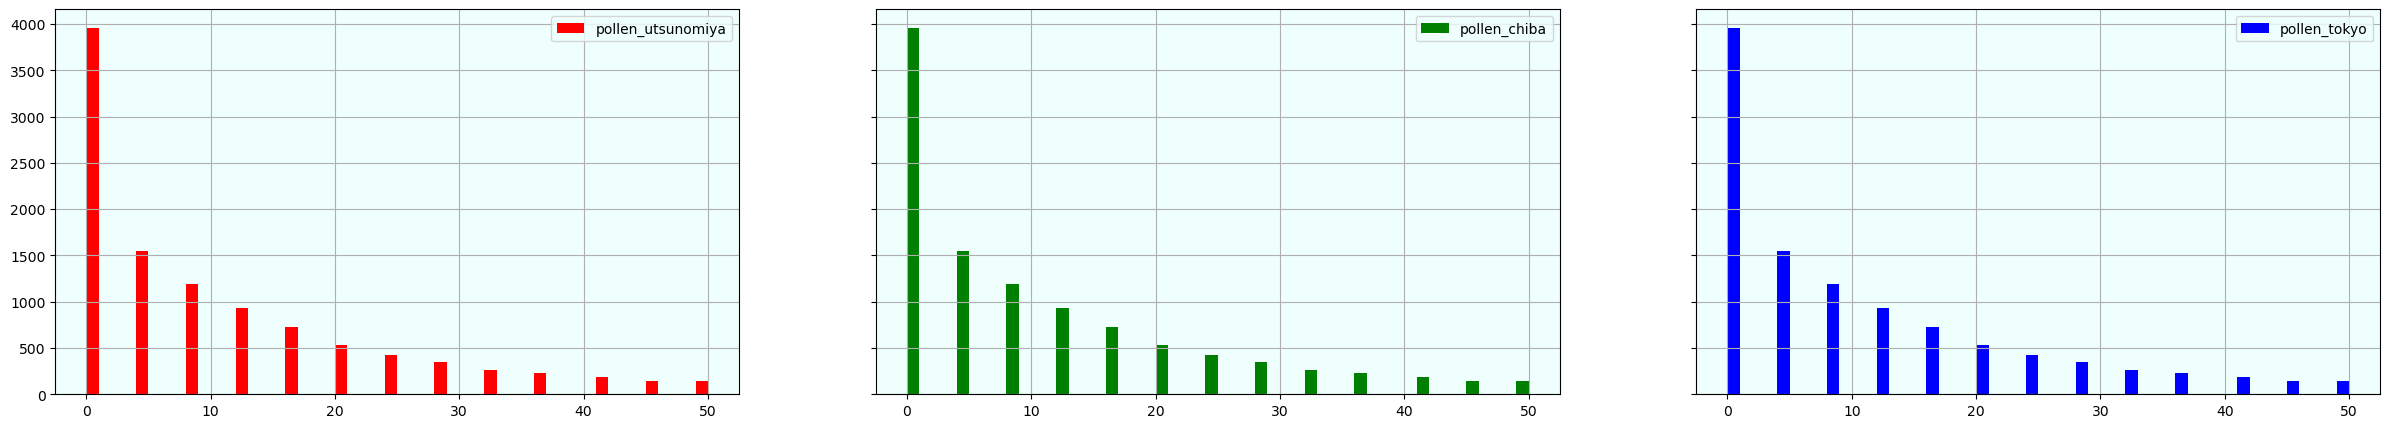

In [23]:
plot_col = ['pollen_utsunomiya', 'pollen_chiba', 'pollen_tokyo']
color = ['red','green','blue']
ncols = len(plot_col)
plt.subplots(1, ncols, sharey=True, sharex=True, figsize=(30, 5))
plt.grid()
for i, col in enumerate(plot_col):
    plt.subplot(1, ncols, i+1)
    train_df['pollen_chiba'].hist(range=(0,50), bins=50, alpha=1, color=color[i], label=col)
    plt.legend()
plt.show()

In [1]:
target_columns = ['pollen_utsunomiya', 'pollen_chiba', 'pollen_tokyo']

# Sub1(簡易の予測)
results_sub1 = dict()
set_seed(seed)
for tcol in tqdm(target_columns):
    train_tmp = train_df.copy()
    test_tmp = test_df.copy()
    va_preds = []
    test_preds = []
    losses = []
    for i, year in enumerate([2017, 2018, 2019]):    
        tr_df = train_tmp[train_tmp['datetime']<year*1e6+40101]
        va_df = train_tmp[(train_tmp['year']==year)&(train_tmp['month']==4)&(train_tmp['day']<15)]
        feature_columns = [c for c in tr_df.columns if c not in target_columns if c not in ['datetime', 'time', 'year', 'month', 'weekday']]
        # train / validation / test
        tr_x = tr_df[feature_columns]
        tr_y = tr_df[tcol]/4
        va_x = va_df[feature_columns]
        va_y = va_df[tcol]/4
        test_x = test_tmp[feature_columns]
        # training
        model = ModelLgb(plot=plot_mode)
        model.fit(tr_x, tr_y, va_x, va_y)
        # predict
        test_pred = model.predict(test_x).reshape(-1)
        test_pred = np.where(test_pred < 0, 0, test_pred) # post-processing
        test_preds.append(test_pred)
    # preds
    preds = np.mean(test_preds, axis=0)
    # save per target
    results_sub1[tcol] = preds

sub[target_columns] = pd.DataFrame(results_sub1).round()*4
display(sub.head(3))
sub.to_csv("output/02.LightGBMsub1.csv", index=False)

# Sub2(0のみ)
sub[target_columns] = 0
display(sub.head(3))
sub.to_csv("output/02.LightGBMsub2.csv", index=False)

# Sub3(4のみ)
sub[target_columns] = 4
display(sub.head(3))
sub.to_csv(os.path.join(OUTPUT, "sub3.csv"), index=False)

# Sub4(8のみ)
sub[target_columns] = 8
display(sub.head(3))
sub.to_csv("output/02.LightGBMsub4.csv", index=False)

NameError: name 'set_seed' is not defined

In [25]:
train_df["year_mean_x"]

,year_mean_x,year_mean_x,year_mean_x,year_mean_x
0,0.108762,0.095688,14.689402,3.074715
1,0.108762,0.095688,14.689402,3.074715
2,0.108762,0.095688,14.689402,3.074715
3,0.108762,0.095688,14.689402,3.074715
4,0.108762,0.095688,14.689402,3.074715
...,...,...,...,...
12143,0.087172,0.092842,10.137704,3.191212
12144,0.087172,0.092842,10.137704,3.191212
12145,0.087172,0.092842,10.137704,3.191212
12146,0.087172,0.092842,10.137704,3.191212
